In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

%matplotlib inline

In [14]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [15]:
X.shape, y.shape

((70000, 784), (70000,))

In [16]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,train_size=60000,test_size=10000)

# performing preprocessing part 
from sklearn.preprocessing import StandardScaler 
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [12]:
def find_best_hyper_parameters(X,y, show_plot=True):
    #Define a pipeline to search for the best combination of PCA truncation
    #and classifier regularization.
    pca=PCA()
    # set the tolerance to a large value to make the example faster
    logistic=LogisticRegression(random_state=0, multi_class='auto', class_weight='balanced', max_iter=10000, tol=0.1)
    #logistic=svm.SVC(random_state=0, class_weight='balanced', gamma='auto')
    pipe=Pipeline(steps=[('pca', pca), ('logistic', logistic)])

    X_digits, y_digits = X, y #x_train, y_train #datasets.load_digits(return_X_y=True)

    # Parameters of pipelines can be set using ‘__’ separated parameter names:
    param_grid = {
        'pca__n_components': [27],
        'logistic__C': np.logspace(-4, 4, 5),
        #'logistic__penalty': ['l1', 'l2'],
        'logistic__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
        #'svc__kernel': ['linear', 'poly', 'rbf'],
        
    }
    search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, return_train_score=False)
    search.fit(X_digits, y_digits)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    
    if show_plot:
        # Plot the PCA spectrum
        pca.fit(X_digits)

        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
        ax0.plot(pca.explained_variance_ratio_, linewidth=2)
        ax0.set_ylabel('PCA explained variance')

        ax0.axvline(search.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen')
        ax0.legend(prop=dict(size=12))

        # For each number of components, find the best classifier results
        results = pd.DataFrame(search.cv_results_)
        components_col = 'param_pca__n_components'
        best_clfs = results.groupby(components_col).apply(lambda g: g.nlargest(1, 'mean_test_score'))

        best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score', legend=False, ax=ax1)
        ax1.set_ylabel('Classification accuracy (val)')
        ax1.set_xlabel('n_components')

        plt.tight_layout()
        plt.show()

    return search

In [17]:
from sklearn.metrics import accuracy_score
logreg=LogisticRegression()
logreg.fit(x_train,y_train)
pred=logreg.predict(x_test)
accuracy_score(y_test,pred)
#logreg.score(x_test,y_test)

/home/sonamsk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sonamsk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9198

Best parameter (CV score=0.884):
{'logistic__C': 100.0, 'logistic__multi_class': 'auto', 'logistic__solver': 'lbfgs', 'pca__n_components': 27}


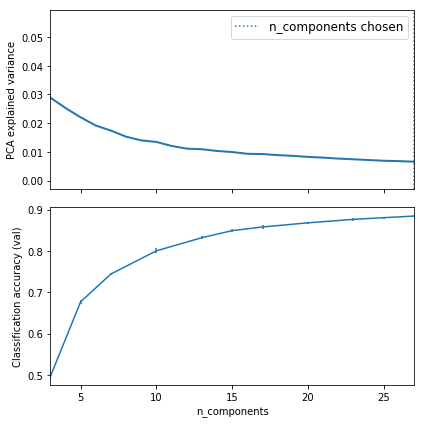

In [28]:
final_clf_x_train = find_best_hyper_parameters(x_train, y_train, show_plot=True)

In [ ]:
pred=final_clf_x_train.predict(x_test)
submission = pd.DataFrame()
submission['target']=pred
submission.to_csv('submission.csv',header=True,index=False)